# From Lab  to Lecture: 

## Analyzing the Connection Between Professors’ Research and Course Content​ 👩‍🏫

**Authors**:
- Erik Wold Riise, s194633​
- Lukas Rasocha, s233498​
- Zou Yong Nan Klaassen, s230351

![Intro Image](./assets/intro.png)


*Image Prompt: minimalistic network visualization with two nodes: one representing a professor and the other a course they teach, connected by a single edge*


### Data Overview 📊

We collected data from 3 separate sources. The first source is the dtu course base from which we gathered information about the courses and the professors teaching them (including the grades, ratings, descriptions, prerequisites, etc.). The second source is the dtu orbit database, which contains information about the professors and their research from which we scraped all the necessary fields for each professor. The third source is a platform called scholia, which contains additional information about the professors and their research. We used this data to create a bipartite bipartite bipartite bipartite bipartite bipartite bipartite bipartite bipartite network of professors and courses, where the nodes are the professors and the courses they teach, and the edges are the connections between them. 

### Project Overview ✍️

This project investigates the alignment between professors’ research areas and the courses they teach through the angle of network analysis and natural language processing (NLP).
We plan to construct a bipartite graph of professors and courses, and analyze the structural and thematic patterns in teaching and research connections.

The central research question steering the project is:
_"How well do professors’ research areas align with the content and objectives of the courses they teach, and how does this alignment vary across disciplines?"_

To complement this, we also examine:
_"Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?"_

Using NLP techniques, we analyze course descriptions and research topics to measure alignment, and we relate these findings to course evaluations and grades. Additionally, network analysis methods, such as community detection and centrality measures, will be applied to uncover interdisciplinary trends and the influence of professors within the academic network.

By this we hope to shed light on how expertise and teaching intersect, and how does that impact educational outcomes in a broader sense.

### Research Directions

- Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?

- How well do professors’ research areas align with the content and objectives of the courses they teach, and how does this alignment vary across disciplines?

- In a situation where a professor quits, how can we find a suitable replacement based on the research areas of the professor and the courses they teach?


### Imports

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import random
import statistics

import os
import json

from tqdm import tqdm
from bs4 import BeautifulSoup
from scholia import query as scholia_query
from SPARQLWrapper import SPARQLWrapper, JSON
from networkx.drawing.layout import bipartite_layout

## Data acquisition

### Load Course Data

In [4]:
file_path = 'data/course_df.csv'
course_df = pd.read_csv(file_path)

### DTU Orbit Scraper class + Scholia API

In [5]:

class DTUOrbitScraper:
    def __init__(self):
        self.base_url = "https://orbit.dtu.dk/en/persons/"
        self.endpoint_url = "https://query.wikidata.org/sparql"

    def search_person(self, name):
        """Search for the person and get the URL to their profile."""
        search_url = f"{self.base_url}?search={name.replace(' ', '+')}&isCopyPasteSearch=false"
        response = requests.get(search_url)
        
        if response.status_code != 200:
            raise Exception("Failed to fetch search results")
        
        soup = BeautifulSoup(response.text, "html.parser")
        # Find the first profile link (assuming it's the first result)
        profile_link = soup.find("h3", class_="title").find("a", href=True)
        
        if profile_link:
            return profile_link['href']
        else:
            raise Exception("Profile link not found")

    def get_topic_info(self, topic_url):
        """Scrape the description for a topic from its Wikidata page."""
        response = requests.get(topic_url)
        if response.status_code != 200:
            return "Description not found"
        
        soup = BeautifulSoup(response.text, "html.parser")
        description = soup.find("div", class_="wikibase-entitytermsview-heading-description")
        return description.text.strip() if description else "Description not found"

    def get_scholia_topics(self, qs):
        """Get topics and scores from Scholia using SPARQL."""
        query = f"""PREFIX target: <http://www.wikidata.org/entity/{qs}>
        SELECT ?score ?topic ?topicLabel
        WITH {{
            SELECT (SUM(?score_) AS ?score) ?topic WHERE {{
                {{ target: wdt:P101 ?topic . BIND(20 AS ?score_) }}
                UNION {{ SELECT (3 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: ; wdt:P921 ?topic . }} }}
                UNION {{ SELECT (1 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: . ?citing_work wdt:P2860 ?work . ?citing_work wdt:P921 ?topic . }} }}
            }} GROUP BY ?topic
        }} AS %results 
        WHERE {{
            INCLUDE %results
            SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
        }}
        ORDER BY DESC(?score)
        LIMIT 200"""
        
        sparql = SPARQLWrapper(self.endpoint_url)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        topics = [] 

        for result in results["results"]["bindings"]:
            topic_url = result["topic"]["value"]
            topic_label = result["topicLabel"]["value"]
            score = int(result["score"]["value"])
            #info = self.get_topic_info(topic_url)
            #topics[topic_label] = {"score": score, "info": info}
            topics.append({"topic":topic_label, "score": score, "topic_url": topic_url})
        return topics

    def get_profile_info(self, name):
        """Retrieve profile information given a person's name."""
        full_profile_url = self.search_person(name)
        response = requests.get(full_profile_url)
        
        if response.status_code != 200:
            raise Exception("Failed to fetch profile page")
        
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Extract profile information
        profile_info = {}
        
        # Get Profile Description
        profile_header = soup.find("h3", string="Profile")
        profile_section = profile_header.find_next("p") if profile_header else None
        profile_info["Profile_desc"] = profile_section.get_text(strip=True) if profile_section else "None"
        
        # Get Keywords
        keywords_section = soup.find("div", class_="keyword-group")
        if keywords_section:
            keywords = [keyword.get_text(strip=True) for keyword in keywords_section.find_all("li", class_="userdefined-keyword")]
            profile_info["Keywords"] = keywords
        else:
            profile_info["Keywords"] = []

        # Get Fingerprint (Concepts, Thesauri, Values)
        fingerprints = []
        fingerprint_section = soup.find("div", class_="person-top-concepts")
        if fingerprint_section:
            fingerprint_items = fingerprint_section.find_all("li", class_="concept-badge-large-container")
            for item in fingerprint_items:
                concept = item.find("span", class_="concept").get_text(strip=True) if item.find("span", class_="concept") else "N/A"
                thesauri = item.find("span", class_="thesauri").get_text(strip=True) if item.find("span", class_="thesauri") else "N/A"
                value = item.find("span", class_="value sr-only").get_text(strip=True) if item.find("span", class_="value sr-only") else "N/A"
                fingerprints.append({
                    "Concept": concept,
                    "Thesauri": thesauri,
                    "Value": value
                })
        profile_info["Fingerprint"] = fingerprints

        # Extract ORCID
        orcid_section = soup.find("div", class_="rendering_person_personorcidrendererportal")
        if orcid_section:
            orcid_link = orcid_section.find("a", href=True)
            profile_info["ORCID"] = orcid_link["href"] if orcid_link else "Not found"
            if orcid_link:
                orcid_id = orcid_link["href"].split("/")[-1]
                profile_info["QS"] = scholia_query.orcid_to_qs(orcid_id)
                # Retrieve Scholia topics if QS exists
                if len(profile_info["QS"]) == 1:
                    profile_info["scholia_topics"] = self.get_scholia_topics(profile_info["QS"][0])
                else:
                    profile_info["scholia_topics"] = {}
        else:
            profile_info["ORCID"] = "Not found"
            profile_info["QS"] = "Not found"
            profile_info["scholia_topics"] = {}

        return profile_info

### Scrape Professors information

In [6]:
scraper = DTUOrbitScraper()

professor_columns = [
    "MAIN_RESPONSIBLE_NAME", "CO_RESPONSIBLE_1_NAME",
    "CO_RESPONSIBLE_2_NAME", "CO_RESPONSIBLE_3_NAME", "CO_RESPONSIBLE_4_NAME"
]

# Extract unique professors from the dataset
def extract_professors(dataframe, professor_columns):
    professors = set()
    for col in professor_columns:
        professors.update(dataframe[col].dropna().unique())
    return list(professors)


def scrape_professor_data(professors, output_file):
    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Skipping scraping.")
        return

    all_data = {}

    for professor in tqdm(professors, desc="Scraping Professors"):
        if professor in all_data:
            print(f"Skipping {professor} as it already exists in the JSON file.")
            continue

        try:
            profile_info = scraper.get_profile_info(professor)
            all_data[professor] = profile_info  # Add to dictionary
        except Exception as e:
            print(f"Failed to scrape data for {professor}: {str(e)}")
            continue

    with open(output_file, "w") as f:
        json.dump(all_data, f, indent=4)
    
    print(f"Saved all professor data to {output_file}")


output_file = "data/all_professors.json"
professors = extract_professors(course_df, professor_columns)
scrape_professor_data(professors, output_file)

File data/all_professors.json already exists. Skipping scraping.


### Load Professors data

In [7]:
with open("data/all_professors.json", "r") as f:
    professors_data = json.load(f)

### Data Cleaning and Preprocessing
Write in more detail about your choices in data cleaning and preprocessing
Did you do analyses / calculate statistics that didn't make it to the main text, put them here.

### Explaratory Data Analysis of the Network

- Lecture 1, 2, 3, 4, 5

In [93]:
blue = '#17BEBB'
orange = '#FF6F61' 
light_blue = '#7FDBFF'
light_orange = '#FF9F7F' 
green = '#2ECC40' 
red = '#FF4136' 
purple = '#B10DC9'  
yellow = '#FFDC00'  
pink = '#F012BE'  
teal = '#39CCCC'  
lime = '#01FF70' 
gray = '#AAAAAA'

#### Create Bipartite Graph

In [11]:
B = nx.Graph()

professors = extract_professors(course_df, professor_columns)
courses = course_df["COURSE"].unique()
professors.remove("NO_DATA")

B.add_nodes_from(professors, bipartite=0, type="Professor")  # Professors
B.add_nodes_from(courses, bipartite=1, type="Course")  # Courses

# Add edges based on professor-course relationships
for _, row in course_df.iterrows():
    course = row["COURSE"]
    for col in professor_columns:
        professor = row[col]
        if pd.notna(professor) and professor != "NO_DATA":  
            B.add_edge(professor, course)

# Add metadata to nodes
for professor in professors:
    if professor in professors_data:
        # Add professor metadata (e.g., research areas)
        B.nodes[professor]["Profile_desc"] = professors_data[professor].get("Profile_desc", None)
        B.nodes[professor]["Keywords"] = professors_data[professor].get("Keywords", [])
        B.nodes[professor]["Fingerprint"] = professors_data[professor].get("Fingerprint", [])
        B.nodes[professor]["scholia_topics"] = professors_data[professor].get("scholia_topics", [])

for _, row in course_df.iterrows():
    course = row["COURSE"]
    # Add course metadata (e.g., description and objectives)
    B.nodes[course]["COURSE_DESCRIPTION"] = row.get("COURSE_DESCRIPTION", "")
    B.nodes[course]["LEARNING_OBJECTIVES"] = row.get("LEARNING_OBJECTIVES", "")

#check if a course does not have any professors
for course in courses:
    if B.degree(course) == 0:
        B.remove_node(course)
        courses = np.delete(courses, np.where(courses == course))

print(f"Bipartite graph created with {B.number_of_nodes()} nodes and {B.number_of_edges()} edges.")

Bipartite graph created with 2750 nodes and 3143 edges.


Subgraph created with 17 nodes and 12 edges.


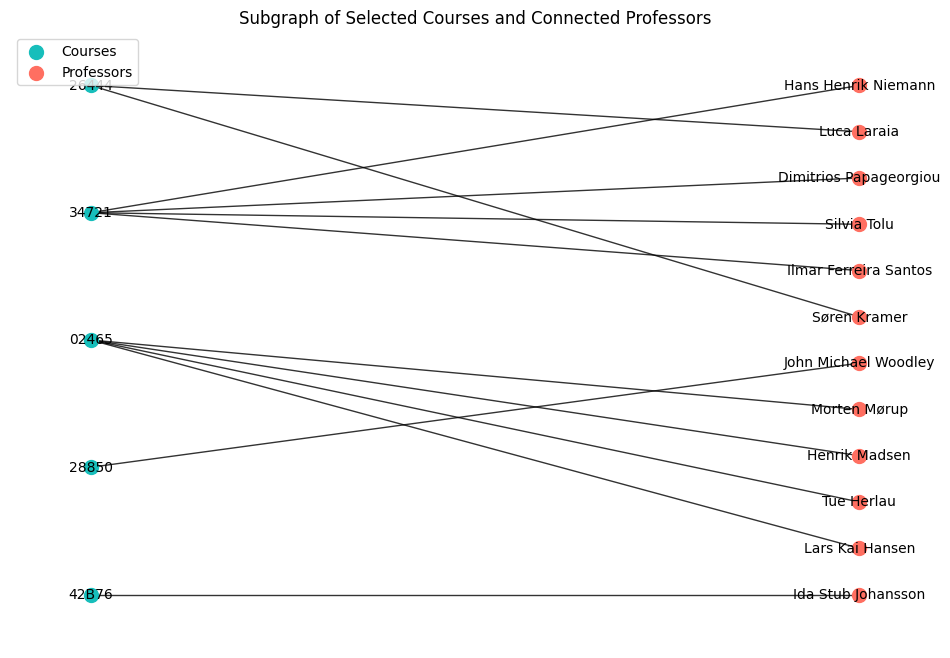

In [98]:
# Select 5 courses from the courses set
selected_courses = random.sample(list(courses), 5)

# Create a subgraph with the selected courses and their connected professors
subgraph_nodes = set(selected_courses)
for course in selected_courses:
    subgraph_nodes.update(B.neighbors(course))

subgraph = B.subgraph(subgraph_nodes)

# Print the number of nodes and edges in the subgraph
print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")
# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = bipartite_layout(subgraph, selected_courses)

# Draw the nodes
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=selected_courses,
    node_color=blue,
    node_size=100,
    label="Courses",
)
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=set(subgraph) - set(selected_courses),
    node_color=orange,
    node_size=100,
    label="Professors",
)

# Draw the edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.8, width=1)

# Add a legend
plt.legend(scatterpoints=1, loc="upper left")

# Draw the labels
nx.draw_networkx_labels(subgraph, pos, font_size=10)

# Add title
plt.title("Subgraph of Selected Courses and Connected Professors")

# Remove axis
plt.axis("off")

# Show the plot
plt.show()

Professor In-Degree Statistics : Average = 2.96, Median = 2.0, Mode = 1, Min = 1, Max = 41
Course In-Degree Statistics : Average = 1.86, Median = 2.0, Mode = 1, Min = 1, Max = 5
Professor Out-Degree Statistics : Average = 2.96, Median = 2.0, Mode = 1, Min = 1, Max = 41
Course Out-Degree Statistics : Average = 1.86, Median = 2.0, Mode = 1, Min = 1, Max = 5


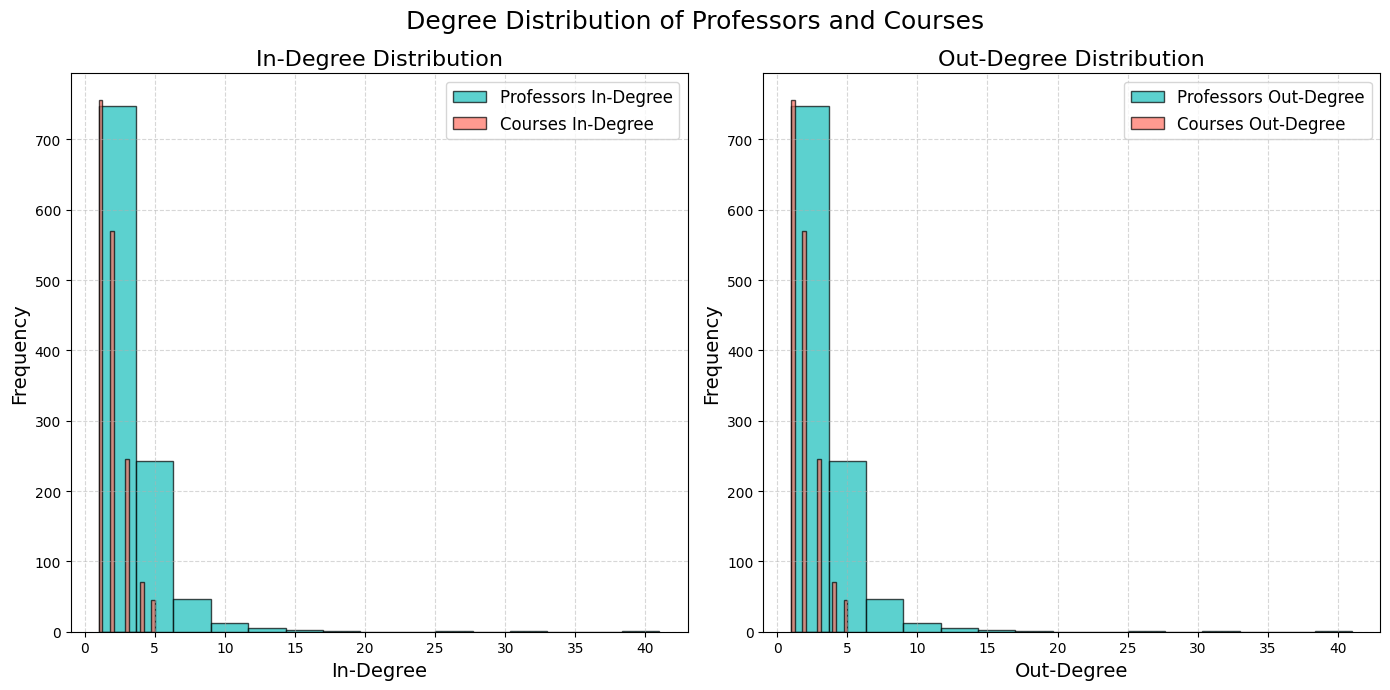

In [97]:
# Convert the bipartite graph to directed graph
B_directed = B.to_directed()

professors = {node for node, data in B_directed.nodes(data=True) if data['bipartite'] == 0}
courses = {node for node, data in B_directed.nodes(data=True) if data['bipartite'] == 1}

professor_in_degrees = [in_degrees[professor] for professor in professors]
course_in_degrees = [in_degrees[course] for course in courses]
professor_out_degrees = [out_degrees[professor] for professor in professors]
course_out_degrees = [out_degrees[course] for course in courses]

professor_in_avg = sum(professor_in_degrees) / len(professor_in_degrees) 
professor_in_median = statistics.median(professor_in_degrees) 
professor_in_mode = statistics.mode(professor_in_degrees) 
professor_in_min = min(professor_in_degrees) 
professor_in_max = max(professor_in_degrees)

course_in_avg = sum(course_in_degrees) / len(course_in_degrees)
course_in_median = statistics.median(course_in_degrees)
course_in_mode = statistics.mode(course_in_degrees)
course_in_min = min(course_in_degrees)
course_in_max = max(course_in_degrees)

professor_out_avg = sum(professor_out_degrees) / len(professor_out_degrees) 
professor_out_median = statistics.median(professor_out_degrees)
professor_out_mode = statistics.mode(professor_out_degrees) 
professor_out_min = min(professor_out_degrees) 
professor_out_max = max(professor_out_degrees) 

course_out_avg = sum(course_out_degrees) / len(course_out_degrees) 
course_out_median = statistics.median(course_out_degrees) 
course_out_mode = statistics.mode(course_out_degrees) 
course_out_min = min(course_out_degrees) 
course_out_max = max(course_out_degrees)

print(f"{'Professor In-Degree Statistics'} : Average = {professor_in_avg:.2f}, Median = {professor_in_median}, Mode = {professor_in_mode}, Min = {professor_in_min}, Max = {professor_in_max}")
print(f"{'Course In-Degree Statistics'} : Average = {course_in_avg:.2f}, Median = {course_in_median}, Mode = {course_in_mode}, Min = {course_in_min}, Max = {course_in_max}")
print(f"{'Professor Out-Degree Statistics'} : Average = {professor_out_avg:.2f}, Median = {professor_out_median}, Mode = {professor_out_mode}, Min = {professor_out_min}, Max = {professor_out_max}")
print(f"{'Course Out-Degree Statistics'} : Average = {course_out_avg:.2f}, Median = {course_out_median}, Mode = {course_out_mode}, Min = {course_out_min}, Max = {course_out_max}")

plt.figure(figsize=(14, 7))

# In-Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(professor_in_degrees, bins=15, color=blue, alpha=0.7, label='Professors In-Degree', edgecolor='black')
plt.hist(course_in_degrees, bins=15, color=orange, alpha=0.7, label='Courses In-Degree', edgecolor='black')
plt.legend(loc='upper right', fontsize=12)
plt.title("In-Degree Distribution", fontsize=16)
plt.xlabel('In-Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Out-Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(professor_out_degrees, bins=15, color=blue, alpha=0.7, label='Professors Out-Degree', edgecolor='black')
plt.hist(course_out_degrees, bins=15, color=orange, alpha=0.7, label='Courses Out-Degree', edgecolor='black')
plt.legend(loc='upper right', fontsize=12)
plt.title("Out-Degree Distribution", fontsize=16)
plt.xlabel('Out-Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Degree Distribution of Professors and Courses", fontsize=18)
plt.tight_layout()
plt.show()

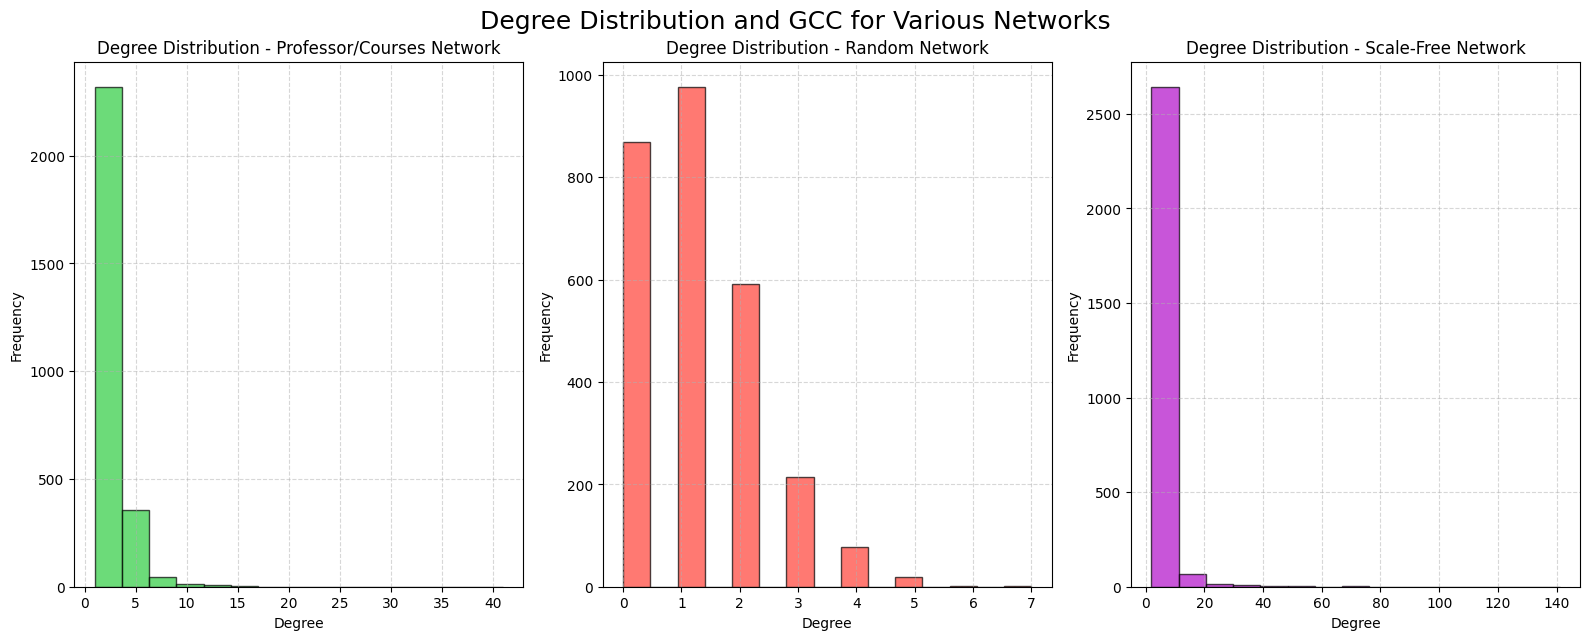

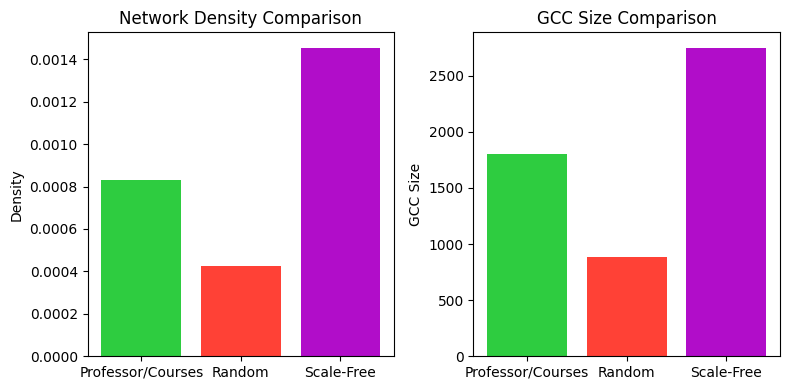

In [142]:
# Function to calculate the size of the Giant Connected Component (GCC)
def get_gcc_size(graph):
    components = list(nx.connected_components(graph))
    largest_component = max(components, key=len)
    return len(largest_component)

# Generate a random Erdős–Rényi network with the same number of nodes and edges
n = len(B.nodes)  # Number of nodes
m = len(B.edges)  # Number of edges
random_graph = nx.erdos_renyi_graph(n, m / (n * (n - 1)))
scale_free_graph = nx.barabasi_albert_graph(n, 2)

# Calculate the GCC size for each network
gcc_bipartite_size = get_gcc_size(B)
gcc_random_size = get_gcc_size(random_graph)
gcc_scale_free_size = get_gcc_size(scale_free_graph)

# Calculate the network density for each graph
density_bipartite = nx.density(B)
density_random = nx.density(random_graph)
density_scale_free = nx.density(scale_free_graph)

plt.figure(figsize=(16, 12))

# Degree distribution for Bipartite Network
plt.subplot(2, 3, 1)
plt.hist([d for n, d in B.degree()], bins=15, color=green, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Professor/Courses Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

# Degree distribution for Random Network
plt.subplot(2, 3, 2)
plt.hist([d for n, d in random_graph.degree()], bins=15, color=red, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Random Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

# Degree distribution for Scale-Free Network
plt.subplot(2, 3, 3)
plt.hist([d for n, d in scale_free_graph.degree()], bins=15, color=purple, alpha=0.7, edgecolor='black')
plt.title("Degree Distribution - Scale-Free Network")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Degree Distribution and GCC for Various Networks", fontsize=18)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

# Network Density Comparison
axes[0].bar(['Professor/Courses', 'Random', 'Scale-Free'], 
            [density_bipartite, density_random, density_scale_free], 
            color=[green, red, purple])
axes[0].set_title("Network Density Comparison")
axes[0].set_ylabel("Density")
axes[0].tick_params(axis='x', rotation=0) 

# GCC Size Comparison
axes[1].bar(['Professor/Courses', 'Random', 'Scale-Free'], 
            [gcc_bipartite_size, gcc_random_size, gcc_scale_free_size], 
            color=[green, red, purple])
axes[1].set_title("GCC Size Comparison")
axes[1].set_ylabel("GCC Size")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [172]:
# Compute degree centrality for the directed graph
degree_centrality = nx.degree_centrality(B_directed)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_degree = sorted_degree[:5]

# Compute betweenness centrality for the directed graph
betweenness_centrality = nx.betweenness_centrality(B_directed)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_betweenness = sorted_betweenness[:5]

# Display the results
print("\nTop 5 Most Central Nodes by Degree Centrality:")
print("-" * 100)
for node, centrality in top_5_degree:
    print(f"Node: {node:<50} Degree Centrality: {centrality:.4f}")
print("\nTop 5 Most Central Nodes by Betweenness Centrality:")
print("-" * 100)
for node, centrality in top_5_betweenness:
    print(f"Node: {node:<50} Betweenness Centrality: {centrality:.4f}")


Top 5 Most Central Nodes by Degree Centrality:
----------------------------------------------------------------------------------------------------
Node: Bjarke Nielsen                                     Degree Centrality: 0.0298
Node: Ida Stub Johansson                                 Degree Centrality: 0.0226
Node: Bo Ea Holst-Christensen                            Degree Centrality: 0.0196
Node: Samuel Brüning Larsen                              Degree Centrality: 0.0124
Node: Martha Lynn Aulbaugh Eriksen                       Degree Centrality: 0.0116

Top 5 Most Central Nodes by Betweenness Centrality:
----------------------------------------------------------------------------------------------------
Node: Wolfgang Dietrich Pantleon                         Betweenness Centrality: 0.1255
Node: Carsten Rützou                                     Betweenness Centrality: 0.1051
Node: 41681                                              Betweenness Centrality: 0.1027
Node: Henning Frii

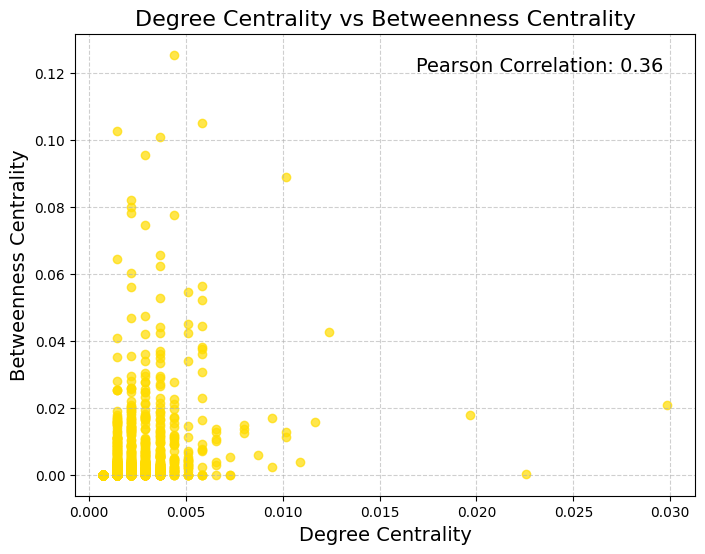

In [173]:
degree_values = list(degree_centrality.values())
betweenness_values = list(betweenness_centrality.values())

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(degree_values, betweenness_values)
correlation = correlation_matrix[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(degree_values, betweenness_values, alpha=0.7, color=yellow)

plt.title("Degree Centrality vs Betweenness Centrality", fontsize=16)
plt.xlabel("Degree Centrality", fontsize=14)
plt.ylabel("Betweenness Centrality", fontsize=14)
plt.text(0.55, 0.95, f"Pearson Correlation: {correlation:.2f}", 
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Exploratory Data analysis of Text

- Lecture 5, 6, 7, 8

### Main Analysis and our Methodology

### Results

### Conclusion